# Semantic Segmentation Using U-Net
### Artificial Intelligence Course | Instructed by DR. MohammadHossein Rohban
<font color='cyan'> Responsible TAs: Amirhossein Razlighi, Reza Vahidimajd </font>

<font color='yellow'> Please ask your questions via [Quera](www.quera.com) </font>

<b>
Ali Ghasemzadeh - 401106339 </br>
Ali Najar - 401102701 </br>
Mohammad Amin Abbasfar - 401106211 </br>
</b>

In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


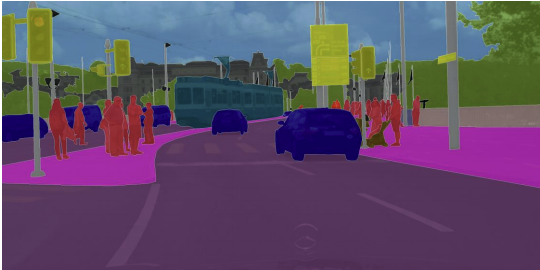 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [1]:
%pip install --upgrade --no-cache-dir gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle datasets download -d mojtabanafez/self-driving-car-dataset-ai-course

Dataset URL: https://www.kaggle.com/datasets/mojtabanafez/self-driving-car-dataset-ai-course
License(s): Apache 2.0
 99%|███████████████████████████████████████▋| 516M/519M [00:14<00:00, 36.1MB/s]
100%|████████████████████████████████████████| 519M/519M [00:15<00:00, 36.3MB/s]


In [3]:
!mv /kaggle/working/self-driving-car-dataset-ai-course.zip /kaggle/working/Files.zip

In [4]:
# !gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

In [5]:
!unzip Files.zip > out.txt

In [6]:
%pip install --upgrade torch torchvision torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [8]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [9]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=5`

/tmp/ipykernel_34/2281520002.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = [imageio.imread(mask_list[i]) for i in range(N)]


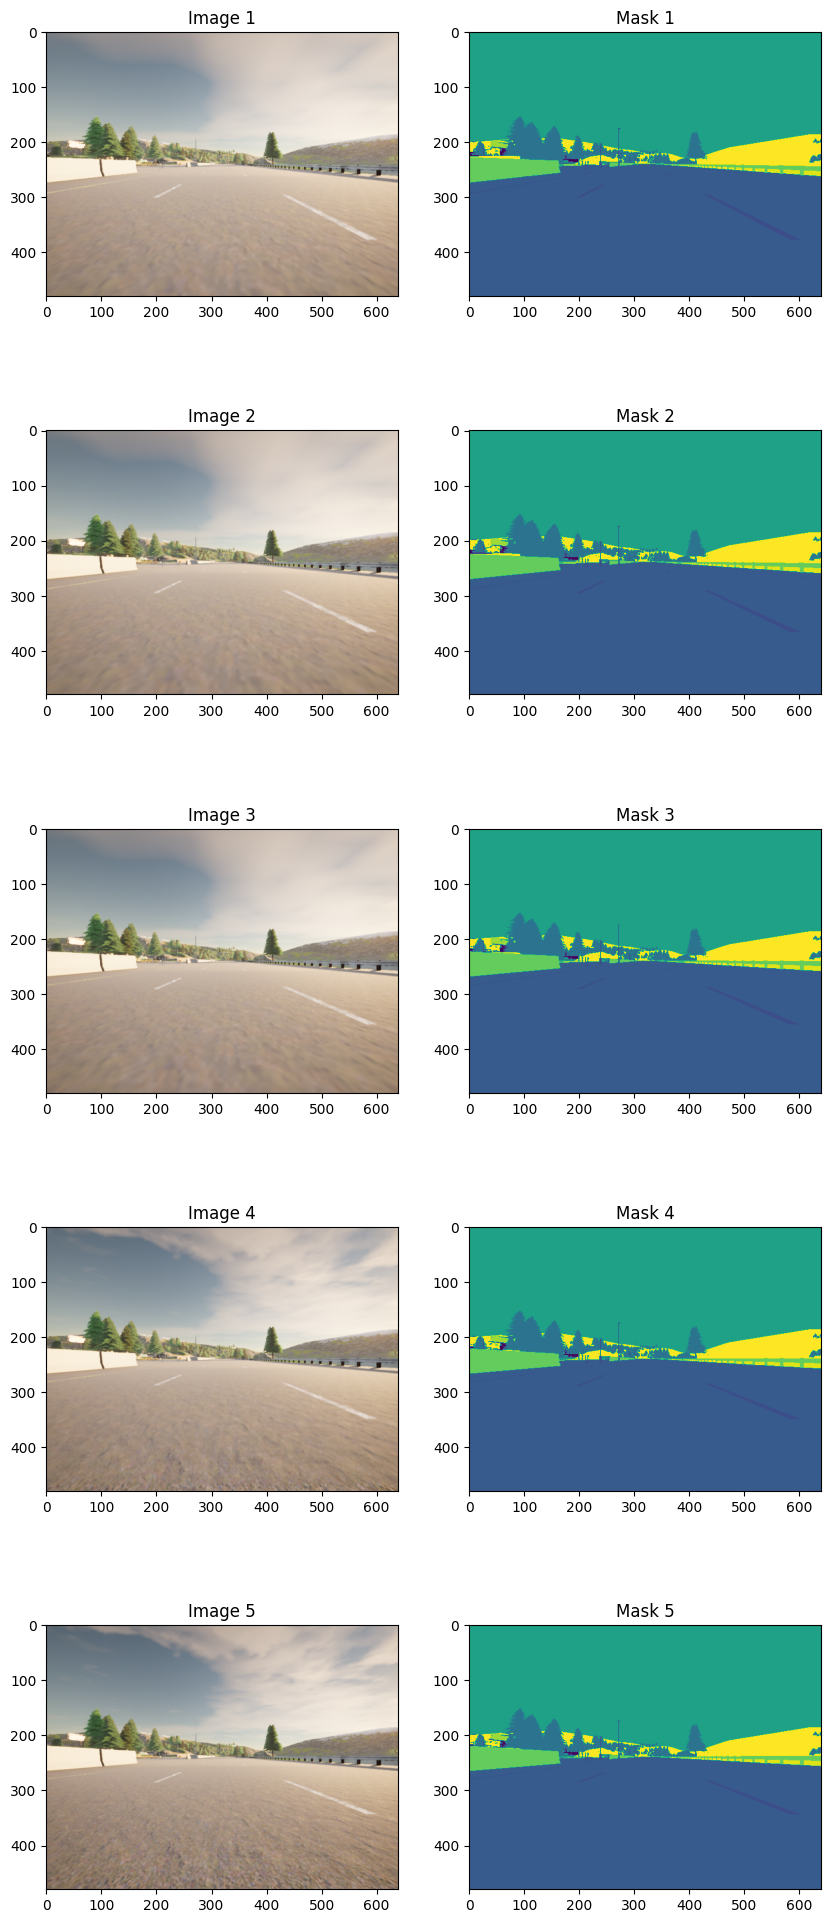

In [233]:
N = 5
# TODO
img = [Image.open(image_list[i]) for i in range(N)]
mask = [imageio.imread(mask_list[i]) for i in range(N)]

fig, axes = plt.subplots(N, 2, figsize=(10, N*5))

for i in range(N):
  axes[i, 0].imshow(img[i])
  axes[i, 0].set_title(f"Image {i+1}")

  axes[i, 1].imshow(mask[i][:,:,0])
  axes[i, 1].set_title(f"Mask {i+1}")

# Plot the images and masks alongside each other

<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [234]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        #TODO: Do anything necessary to initialize the object
        super(Segmentation_Dataset, self).__init__()

        self.image_files = ImagesDirectory
        self.mask_files = MasksDirectory
        
        self.images = []
        self.masks = []
        for i in range(len(self.image_files)):
            image_path = os.path.join(self.image_files[i])
            mask_path = os.path.join(self.mask_files[i])

            self.images.append(Image.open(image_path))
            self.masks.append(Image.open(mask_path))
            
        
        # TODO: Define the mask transforms
        # Your transform should contain: Resizing to 192x256 (and any more things you want to add!)
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.PILToTensor(),
                transforms.Lambda(lambda x : x[0])
            ]
        )
        # TODO: Define the image transforms
        # Your transform should contain: Transforming to PIL image format, resizing to 192x256,
        # converting to tensor and selecting only the first 3 channels (and any more things you want to add!)
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x : x[:3]),
#                 transforms.Normalize([0.485, 0.456, 0.406],
#                      [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        
        image = self.images[index]
        mask = self.masks[index]

        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)

        return image, mask


In [235]:
def plot_item(image, mask):
    image_np = image.cpu().numpy().transpose((1,2,0))
    mask_np = mask.cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(mask_np)
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.show()

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [236]:
EPOCHS = 50
BATCH_SIZE = 16
LR = 0.001
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.

<a name='3-1'></a>
### 3.1 - Model Details

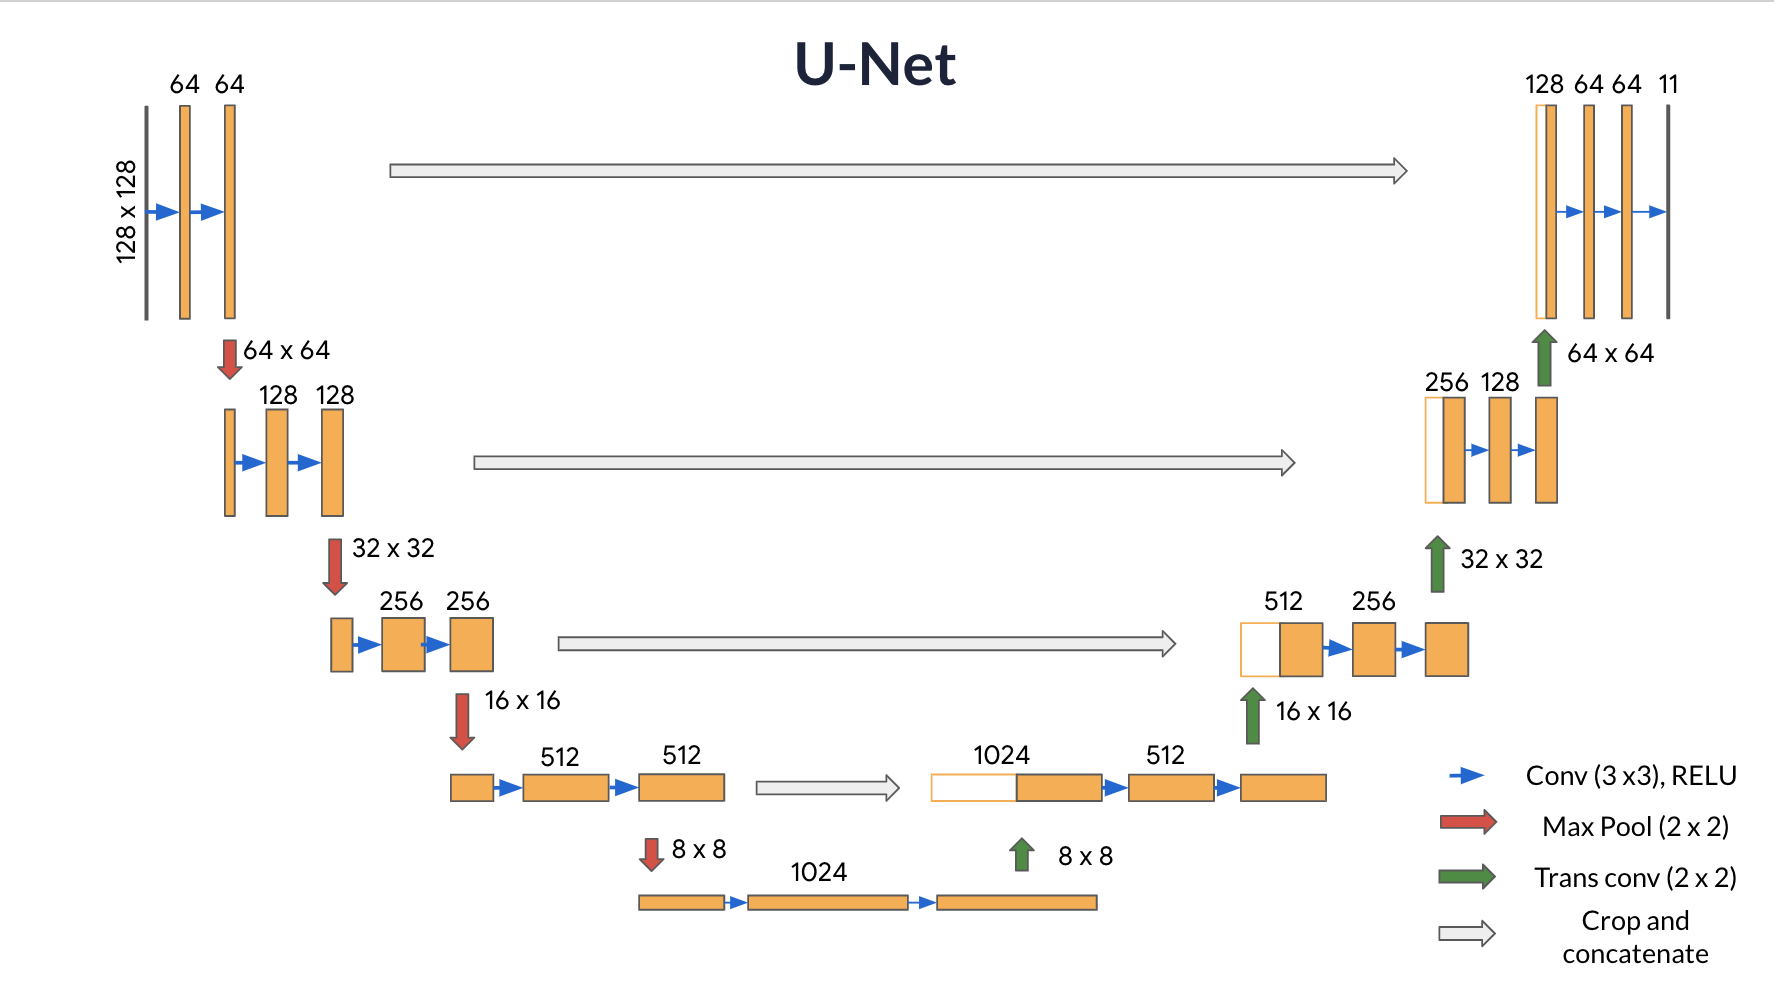<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

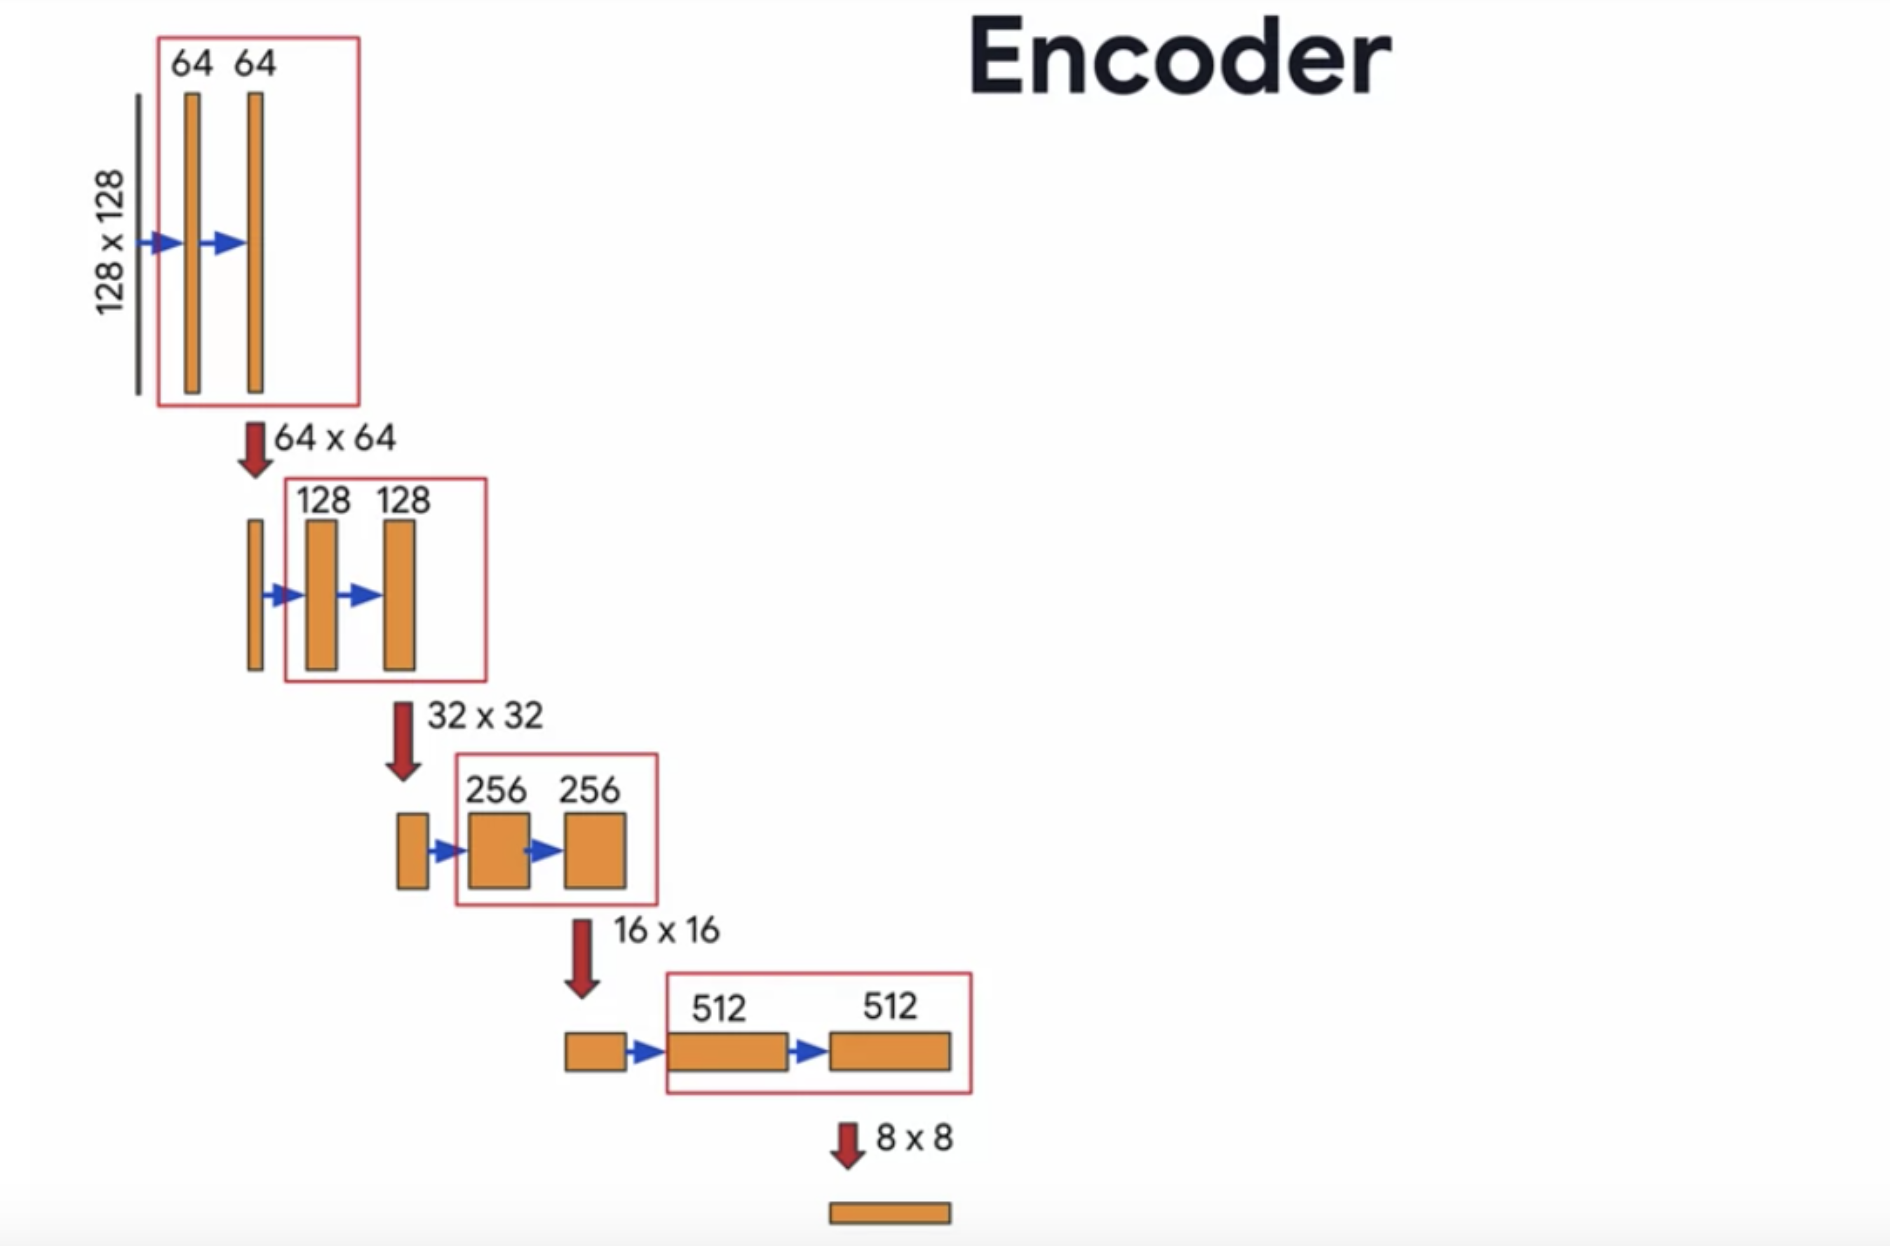<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [237]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()

        self.max_pooling = max_pooling
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
        )
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        skip_connection = self.convs(x)
        next_layer = self.pooling_layer(skip_connection) if self.max_pooling else skip_connection

        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

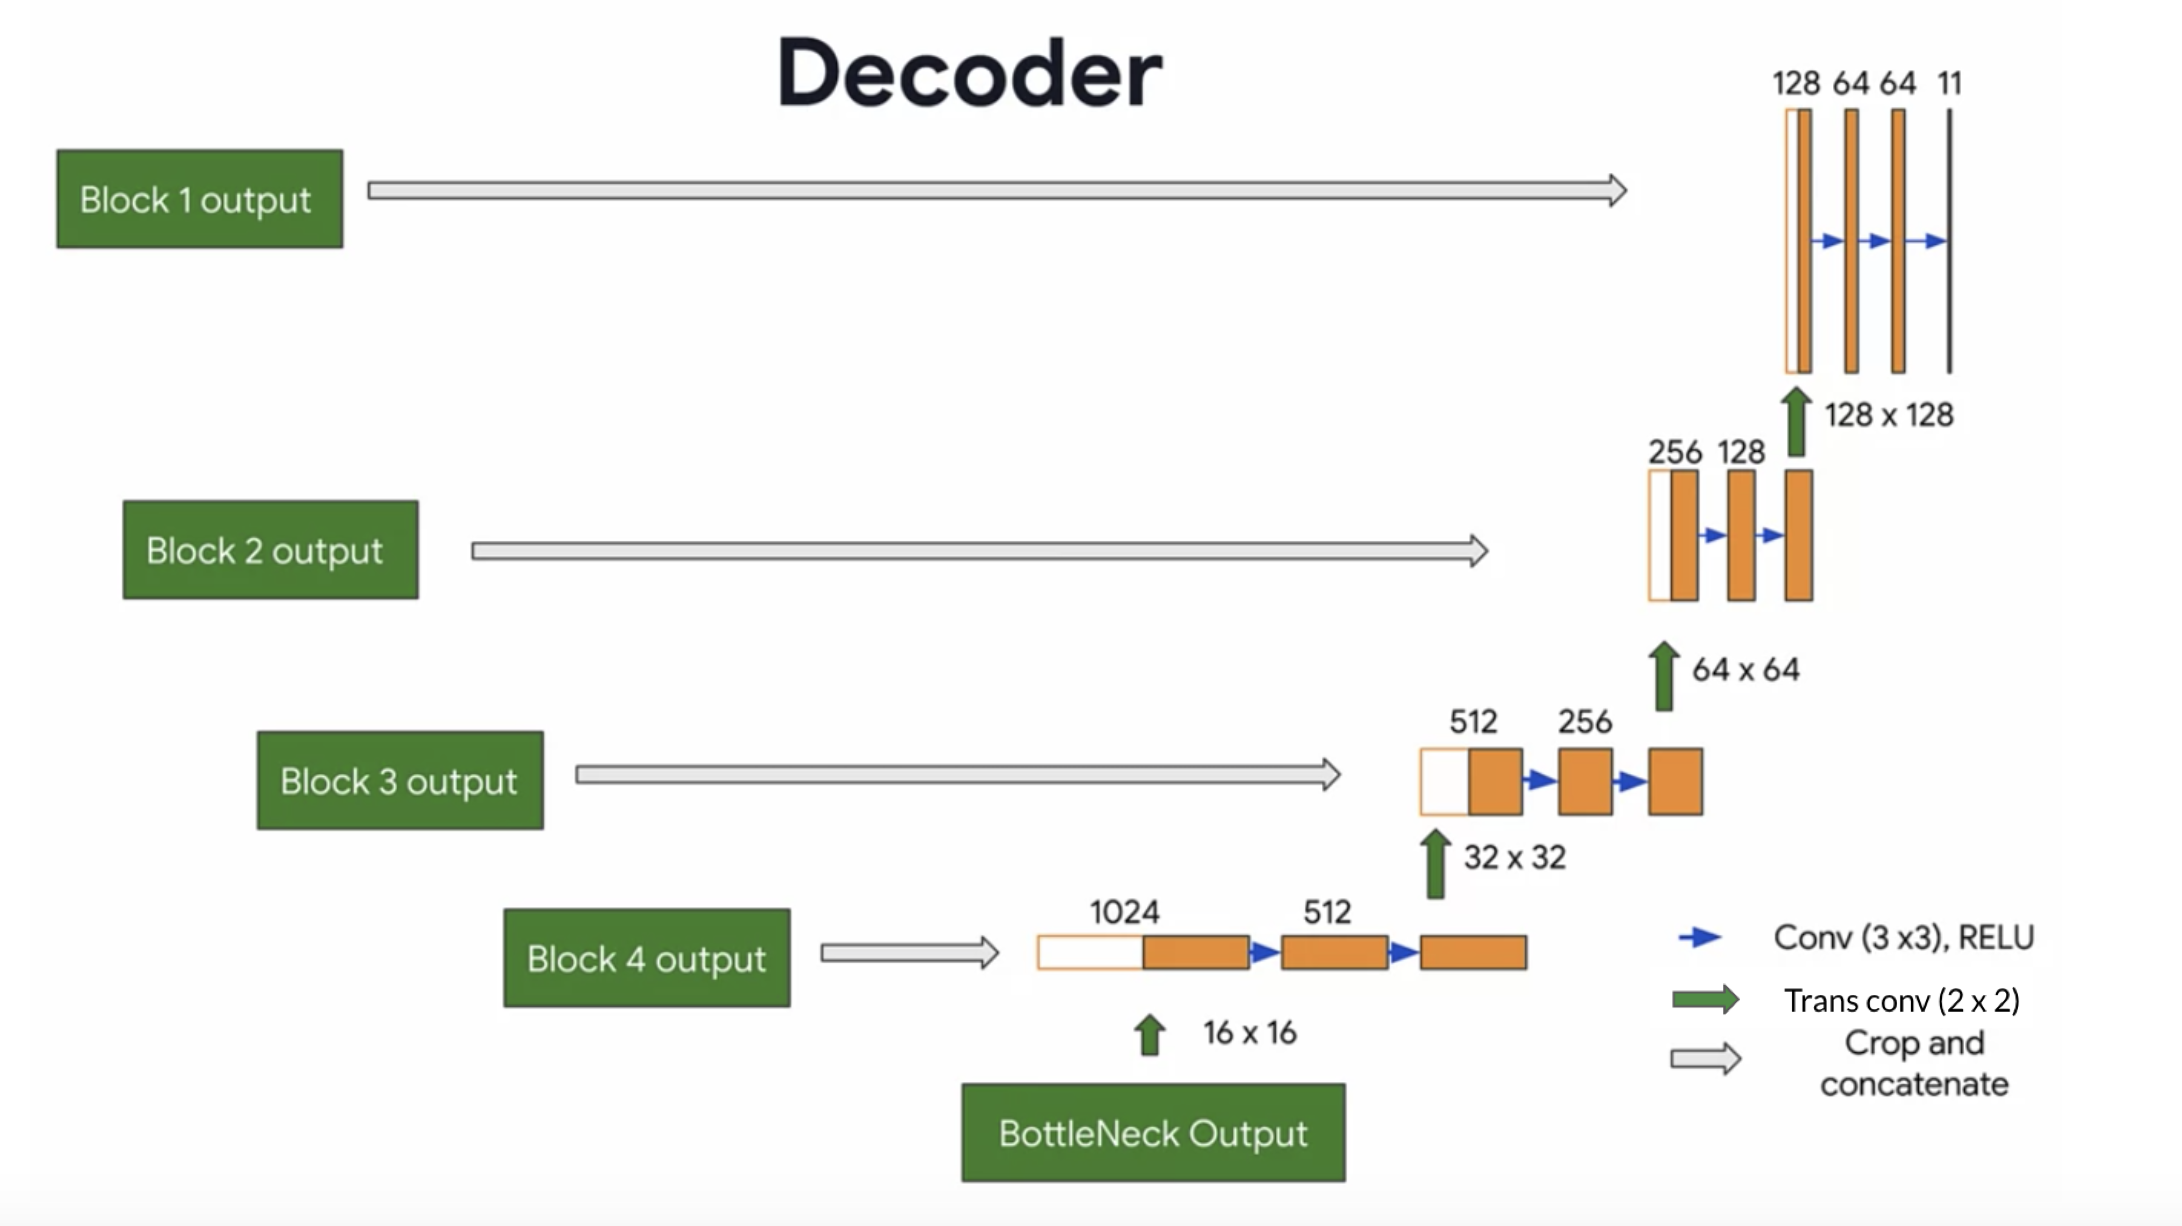<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [192]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        
        self.up_conv = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride = 2)
        self.convs = nn.Sequential(
            nn.Conv2d(n_filters + skip_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
        )

    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        up_conved = self.up_conv(expansive_input)
        cat_inputs = torch.cat((contractive_input, up_conved), dim = 1)
        conv = self.convs(cat_inputs)

        return conv
    

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [238]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        next_layer6 = self.decoder4(next_layer5, skip_connection4)
        next_layer7 = self.decoder3(next_layer6, skip_connection3)
        next_layer8 = self.decoder2(next_layer7, skip_connection2)
        next_layer9 = self.decoder1(next_layer8, skip_connection1)
        
        out = self.final_layer(next_layer9)

        return out

### Check out the model summary

In [239]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             896
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,248
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
           Dropout-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
        conv_block-9  [[-1, 32, 96, 128], [-1, 32, 192, 256]]               0
           Conv2d-10          [-1, 64, 96, 128]          18,496
      BatchNorm2d-11          [-1, 64, 96, 128]             128
             ReLU-12          [-1, 64, 96, 128]               0
           Conv2d-13          [-1, 64, 96, 128]          36,928
      BatchNorm2d-14     

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [240]:
from sklearn.model_selection import train_test_split

train_image, test_image, train_mask, test_mask = train_test_split(image_list, mask_list, test_size=0.2, random_state=42)

train_dataset = Segmentation_Dataset(train_image, train_mask)
test_dataset = Segmentation_Dataset(test_image, test_mask)

train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE)

<Figure size 1500x1500 with 0 Axes>

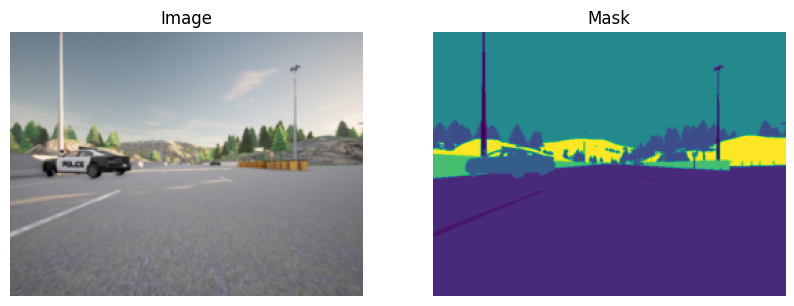

In [241]:
batch_image, batch_mask = next(iter(train_dataloader))

plt.figure(figsize=(15,15))
image = batch_image[0]
mask = batch_mask[0]

plot_item(image, mask)

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [242]:
criterion=nn.CrossEntropyLoss()

In [243]:
optimizer=torch.optim.Adam(unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` loop below to train the model.

In [244]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []

    for i, batch in enumerate(train_dataloader):
        image1, mask1 = batch
        image1 = image1.to(device)
        mask1 = mask1.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = unet(image1)  # Forward pass
                        
        loss = criterion(outputs, mask1.long())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    print(f"EPOCH#{epoch},\t Loss:{mean_loss}")
    losses.append(mean_loss)

EPOCH#0,	 Loss:1.7111539300882592
EPOCH#1,	 Loss:0.859912985900663
EPOCH#2,	 Loss:0.6261280448931568
EPOCH#3,	 Loss:0.5167963296737311
EPOCH#4,	 Loss:0.4328339471007293
EPOCH#5,	 Loss:0.3857717879538266
EPOCH#6,	 Loss:0.3480941338359185
EPOCH#7,	 Loss:0.3625347209426592
EPOCH#8,	 Loss:0.3078836441602347
EPOCH#9,	 Loss:0.2893727674799145
EPOCH#10,	 Loss:0.27906872500788493
EPOCH#11,	 Loss:0.2710292347759571
EPOCH#12,	 Loss:0.25249200047187087
EPOCH#13,	 Loss:0.2414861391737776
EPOCH#14,	 Loss:0.235394187412172
EPOCH#15,	 Loss:0.2395618307702946
EPOCH#16,	 Loss:0.21878641000333823
EPOCH#17,	 Loss:0.2240224964213821
EPOCH#18,	 Loss:0.21410852923708143
EPOCH#19,	 Loss:0.20248863466505734
EPOCH#20,	 Loss:0.19307830142525007
EPOCH#21,	 Loss:0.19095403096585903
EPOCH#22,	 Loss:0.18484112817161488
EPOCH#23,	 Loss:0.18057851774512595
EPOCH#24,	 Loss:0.18121699370303243
EPOCH#25,	 Loss:0.1764331949207018
EPOCH#26,	 Loss:0.17012485215124093
EPOCH#27,	 Loss:0.1738623285068656
EPOCH#28,	 Loss:0.169

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [245]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

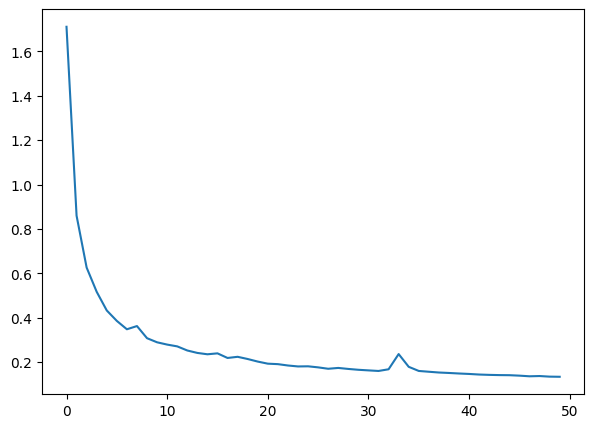

In [246]:
# Create a plot
plt.figure(figsize=(7, 5))

# Plot training errors
plt.plot(losses)

# Display the plot
plt.show()

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images. (Remember that we have 23 classes in our dataset)

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.

**Important Note**: You _can_ use some helper functions from _scikit-learn_ library to calculate mIoU, but you can not use functions (from any library) that calculate mIoU or IoU directly. You need to implement the calculation of mIoU by yourself.

In [247]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes):

    # Implement from scratch. Do not use ready-to-use IoU or mIoU functions from any library
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    cm += confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    iou = np.zeros(num_classes)
    for i in range(num_classes):
      true_positive = cm[i, i]
      false_positive = cm[:, i].sum() - true_positive
      false_negative = cm[i, :].sum() - true_positive

      sums = true_positive + false_positive + false_negative

      if sums == 0:
        iou[i] == np.nan
      else:
        iou[i] = true_positive / sums
    miou = np.nanmean(iou)
    return miou

In [248]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  images, masks = batch
  images = images.to(device)
  masks = masks.to(device)
  with torch.no_grad():
    # TODO: pass images from test dataloader to the model
    # and get the predictions. Then calculate the mious
    # and finally, report the average miou for the test dataset

    model_prediction = unet(images)
    preds = create_mask(model_prediction)
    current_miou = calculate_miou(masks.cpu().numpy(), preds.cpu().numpy(), num_classes)
    mious.append(current_miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.44874456888540887


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [249]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    ######################################################
    ###################### TO DO #########################
    ######################################################
    for i, batch in enumerate(test_dataloader):
        if i > num:
            break
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            model_predictions1 = unet(images)
            preds1 = create_mask(model_predictions1)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(images[0].cpu().permute(1, 2, 0))
        axes[0].set_title("Input Image")

        axes[1].imshow(masks[0].cpu())
        axes[1].set_title("True Mask")

        axes[2].imshow(preds1[0].cpu())
        axes[2].set_title("Predicted Mask")

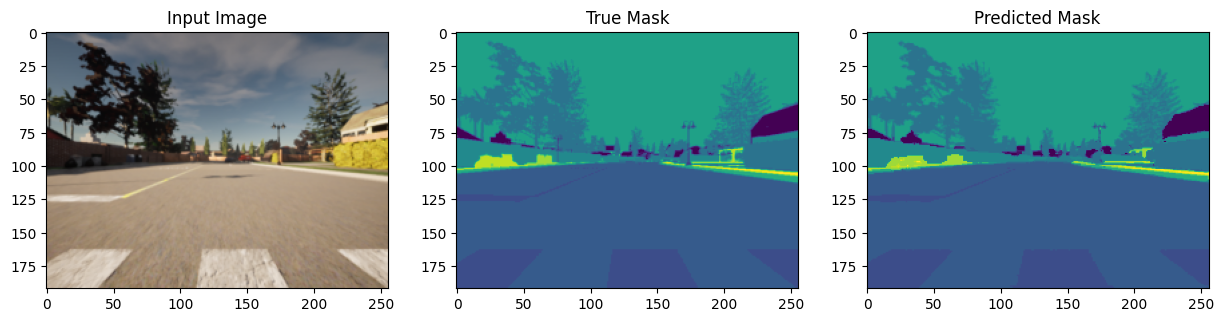

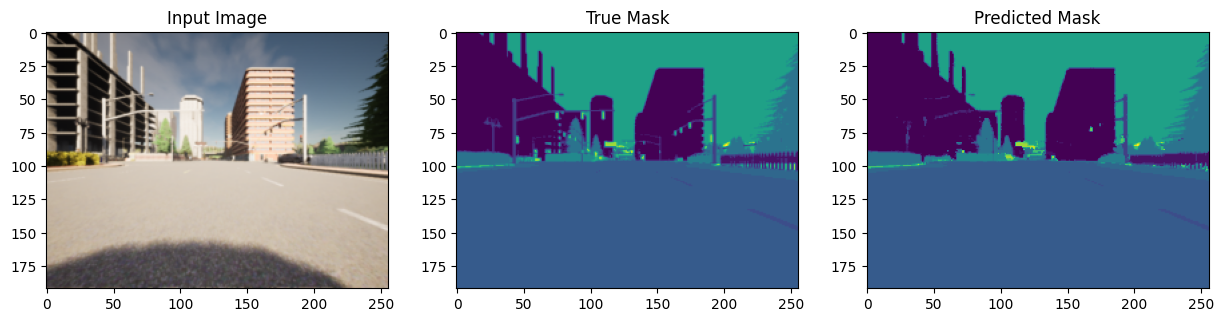

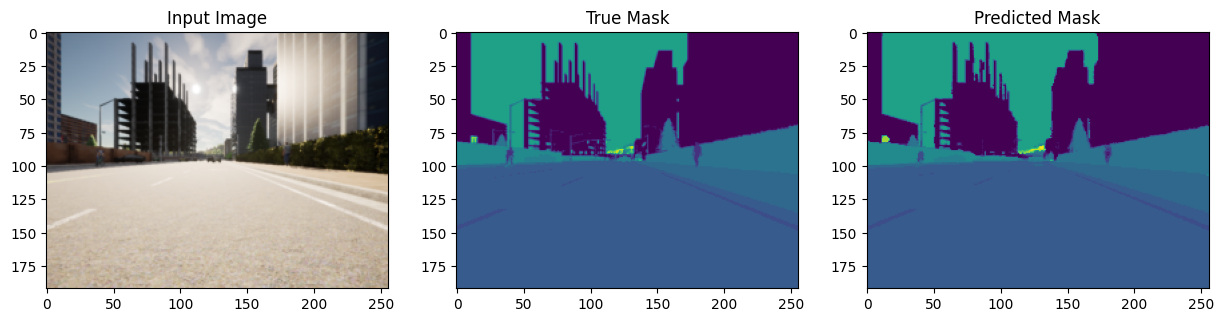

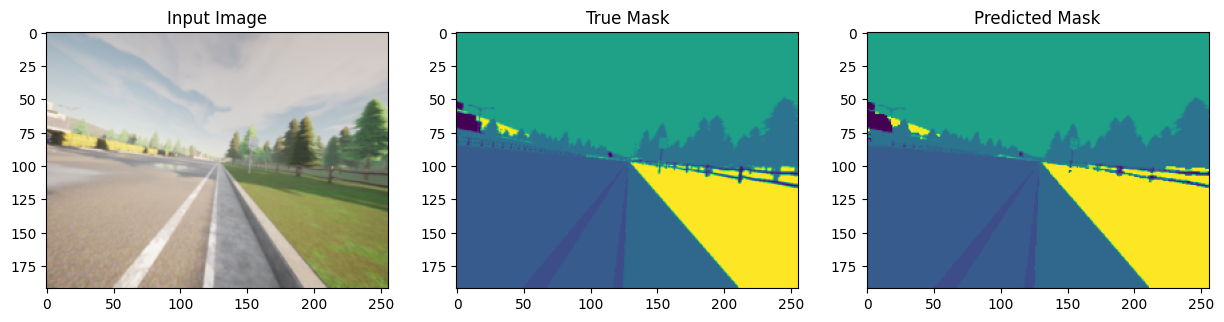

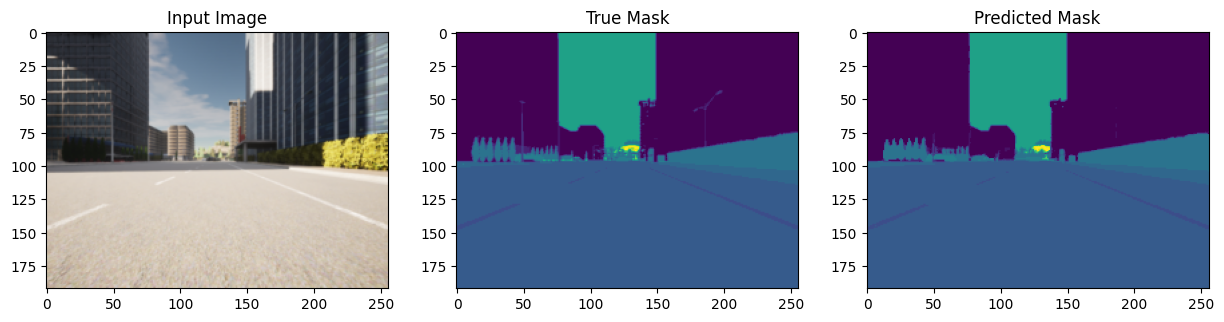

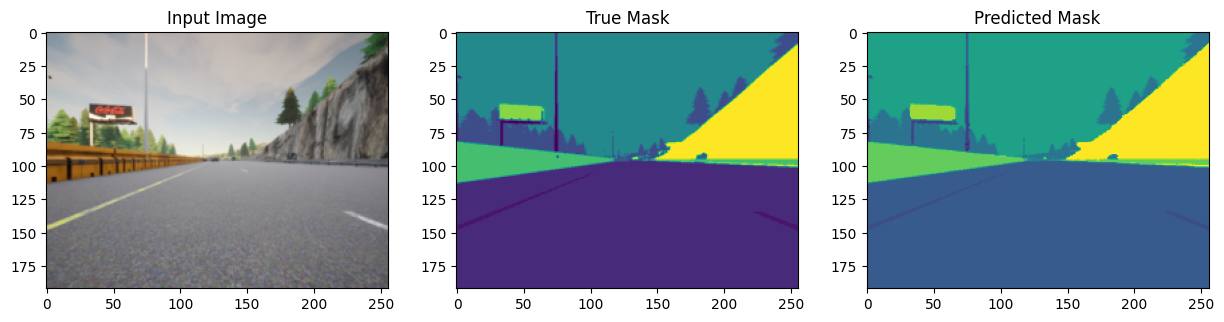

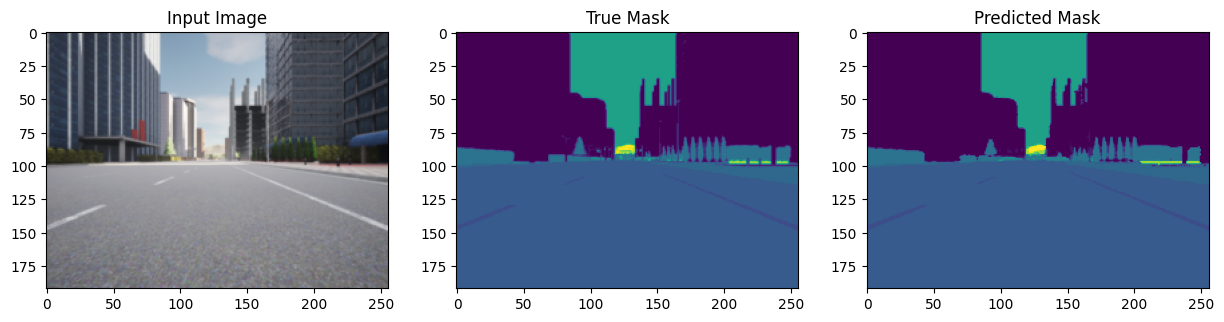

In [250]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [256]:
class CompleteAttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(CompleteAttentionBlock, self).__init__()
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=3, stride = 2, padding = 1),
            nn.BatchNorm2d(F_int),
        )
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.upsample = nn.ConvTranspose2d(F_int, F_l, kernel_size=2, stride = 2)

    def forward(self, x, g):
                
        x_out = self.W_x(x)
        g_out = self.W_g(g)
        relu_out = self.relu(x_out + g_out)
        psi = self.psi(relu_out)
        sig_out = self.sigmoid(psi)
        resampled = self.upsample(sig_out)
        
        return x * resampled

In [257]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.W_g = nn.ConvTranspose2d(F_g, F_int, kernel_size = 2, stride = 2)
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Conv2d(F_int, F_int, kernel_size=1)

    def forward(self, x, g):
                
        x_out = self.W_x(x)
        g_out = self.W_g(g)
        relu_out = self.relu(x_out + g_out)
        psi = self.psi(relu_out)
        
        return x * psi

You can define new `conv_block` and `upsample_block` to meet the requirements of the `AttentionUNet` model. If your previous `conv_block` and `upsample_block` functions are compatible, you can just use them!

In [258]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, n_filters = 32, n_classes = 23):
        """
        UNet with Attention

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            out_channel -- Number of channels of output tensor
        """
        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        
        # Attention Gates
        self.attention4 = AttentionBlock(F_l = 8 * n_filters, F_int = 8 * n_filters, F_g = 16 * n_filters)
        self.attention3 = AttentionBlock(F_l = 4 * n_filters, F_int = 4 * n_filters, F_g = 8 * n_filters)
        self.attention2 = AttentionBlock(F_l = 2 * n_filters, F_int = 2 * n_filters, F_g = 4 * n_filters)
        self.attention1 = AttentionBlock(F_l = n_filters, F_int = n_filters, F_g = 2 * n_filters)


    def forward(self, x):
        """
        UNet with Attention forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        attention_out4 = self.attention4(skip_connection4, next_layer5)
        next_layer6 = self.decoder4(next_layer5, attention_out4)
            
        attention_out3 = self.attention3(skip_connection3, next_layer6)
        next_layer7 = self.decoder3(next_layer6, attention_out3)
        
        attention_out2 = self.attention2(skip_connection2, next_layer7)
        next_layer8 = self.decoder2(next_layer7, attention_out2)
        
        attention_out1 = self.attention1(skip_connection1, next_layer8)
        next_layer9 = self.decoder1(next_layer8, attention_out1)

        
        out = self.final_layer(next_layer9)

        return out

In [259]:
unet = UNet_With_Attention().to(device)

In [260]:
optimizer = optimizer=torch.optim.Adam(unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

criterion = nn.CrossEntropyLoss()

Now, let's implement the training loop for our `Unet with Attention` model. (If you implemented a `train` function for previous part, you can simply reuse it here! If not, you can simply re-implement the loop)

In [261]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []

    for i, batch in enumerate(train_dataloader):
        image1, mask1 = batch
        image1 = image1.to(device)
        mask1 = mask1.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = unet(image1)  # Forward pass
                        
        loss = criterion(outputs, mask1.long())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    print(f"EPOCH#{epoch},\t Loss:{mean_loss}")
    losses.append(mean_loss)

EPOCH#0,	 Loss:1.70466278184135
EPOCH#1,	 Loss:0.8501008816485135
EPOCH#2,	 Loss:0.613451287431537
EPOCH#3,	 Loss:0.5108288588388911
EPOCH#4,	 Loss:0.41977660835913894
EPOCH#5,	 Loss:0.38312902596761594
EPOCH#6,	 Loss:0.35220402760325736
EPOCH#7,	 Loss:0.3150459831615664
EPOCH#8,	 Loss:0.2878834450582288
EPOCH#9,	 Loss:0.2676231939837618
EPOCH#10,	 Loss:0.2635740480333004
EPOCH#11,	 Loss:0.24689519714634373
EPOCH#12,	 Loss:0.2356720190003233
EPOCH#13,	 Loss:0.23337830490661118
EPOCH#14,	 Loss:0.22018438268382595
EPOCH#15,	 Loss:0.20725253758565435
EPOCH#16,	 Loss:0.22571285771873761
EPOCH#17,	 Loss:0.21113130450248718
EPOCH#18,	 Loss:0.19261372314309175
EPOCH#19,	 Loss:0.1809781460829501
EPOCH#20,	 Loss:0.1747641718050219
EPOCH#21,	 Loss:0.17068577628090698
EPOCH#22,	 Loss:0.16632045355607877
EPOCH#23,	 Loss:0.1622154912296331
EPOCH#24,	 Loss:0.161206953086943
EPOCH#25,	 Loss:0.15897774119984429
EPOCH#26,	 Loss:0.1525871478161722
EPOCH#27,	 Loss:0.15087059055859187
EPOCH#28,	 Loss:0.14

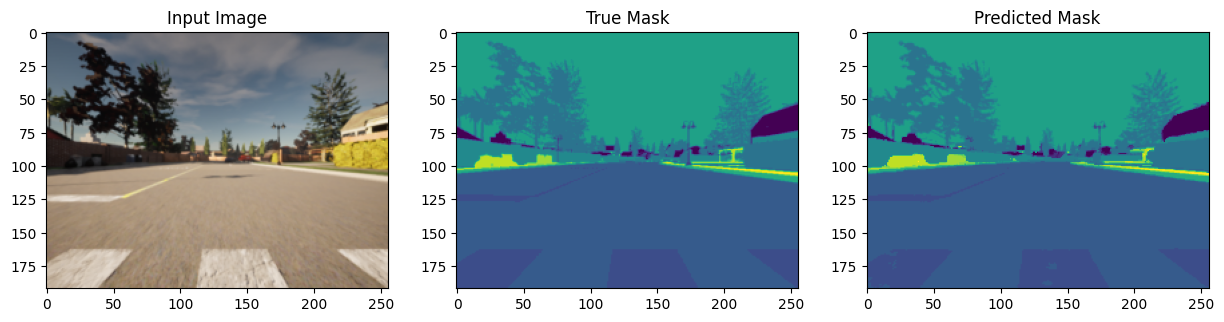

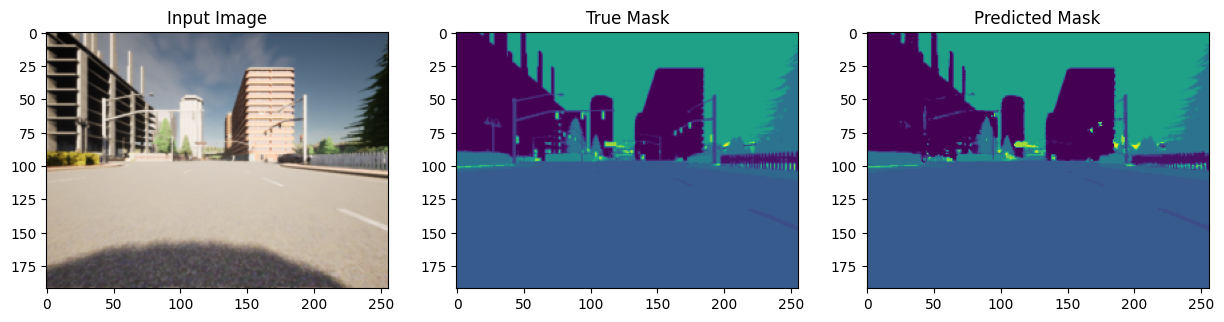

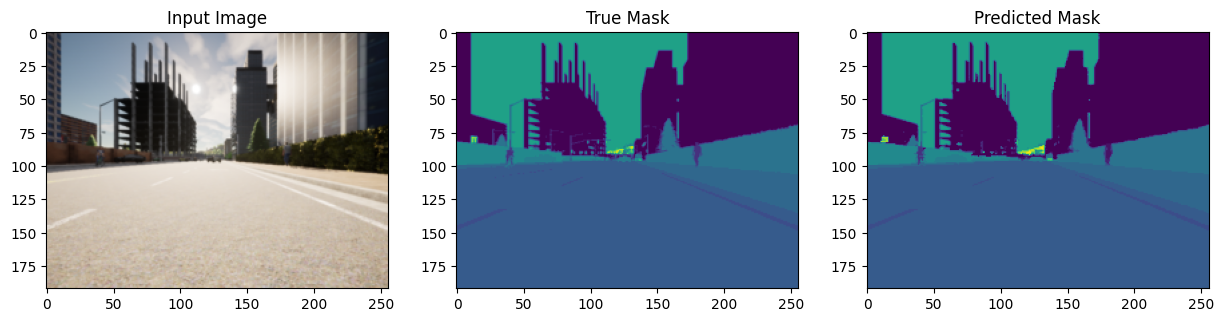

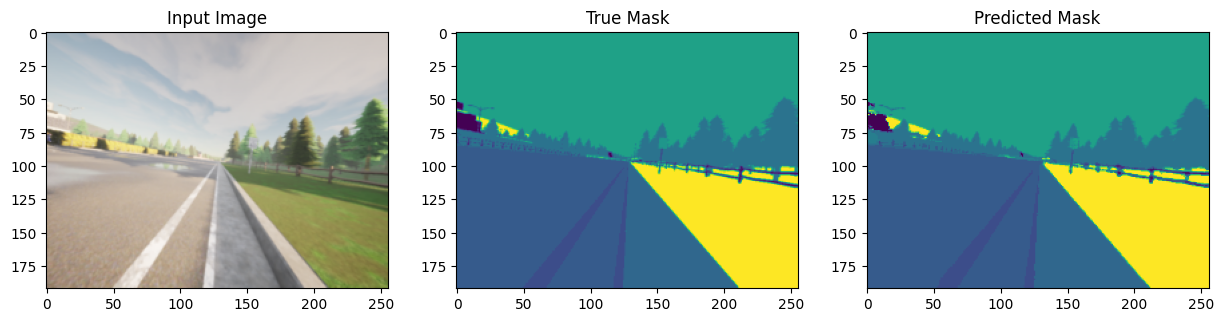

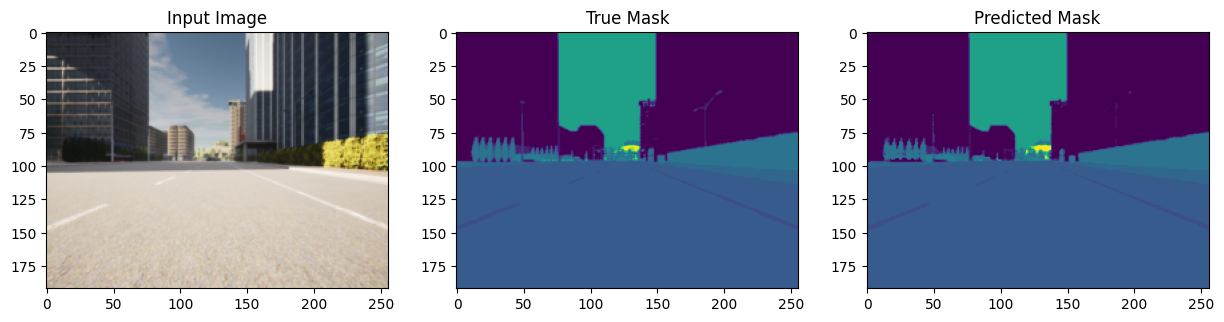

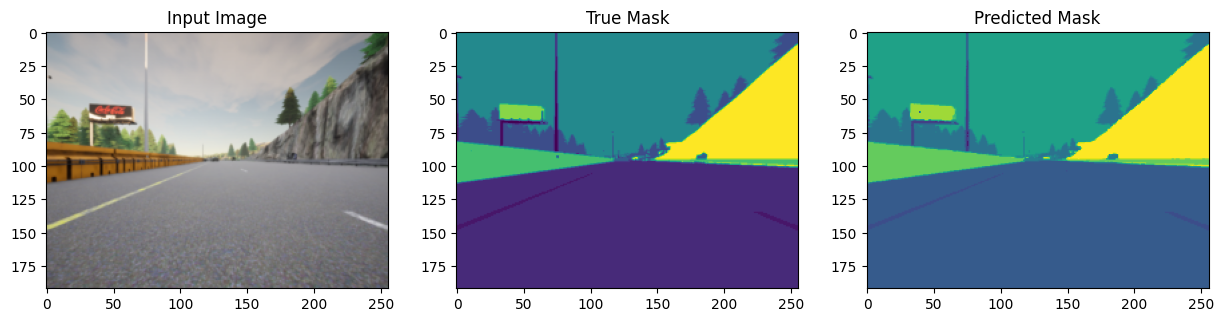

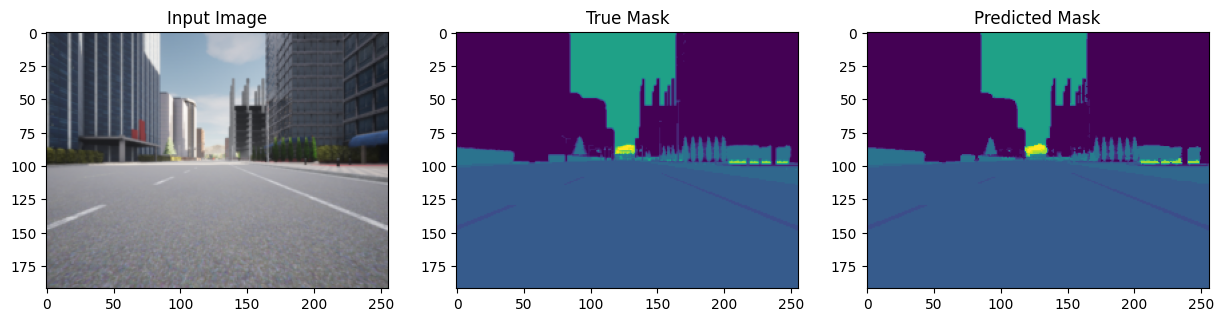

In [262]:
show_predictions(test_dataloader, device, 6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

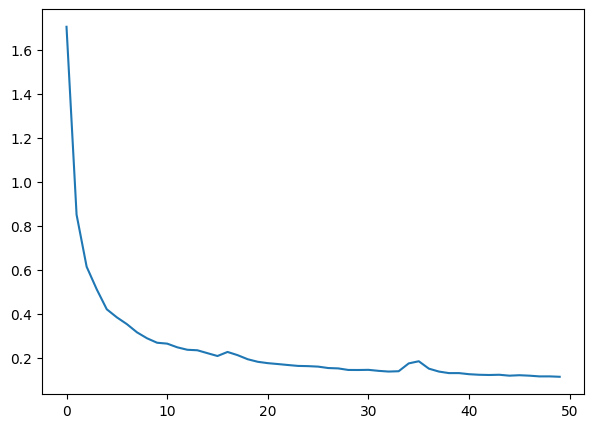

In [263]:
# Create a plot
plt.figure(figsize=(7, 5))

# Plot training errors
plt.plot(losses)

# Display the plot
plt.show()

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [264]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  images, masks = batch
  images = images.to(device)
  masks = masks.to(device)
  with torch.no_grad():
    # TODO: pass images from test dataloader to the model
    # and get the predictions. Then calculate the mious
    # and finally, report the average miou for the test dataset

    model_prediction = unet(images)
    preds = create_mask(model_prediction)
    current_miou = calculate_miou(masks.cpu().numpy(), preds.cpu().numpy(), num_classes)
    mious.append(current_miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.4923606561210025


### 5.3
Compare the results between `Unet` and `AttentionUNet` models. Do your comparison in terms of `mIoU` and `loss` values, and also the `training time`. Which one is better in each of these metrics? Explain your answer based on the outputs and plots and loss values and mIoU values.

The results of AttentionUNet is better in terms of mIoU and loss (mIoU of AttentionUNet is about 9.8% more than UNet). However, the training time is higher for AttentionUNet due to its more complicated architecture. </br>
Thus, the superiority of each model depends on the usecase (the amount of resource we have or how accurate we want our model to be). But in general, higher accuracy worths spending more time for training. So, The AttentionUNet is better than UNet in most cases.